## Resting EEG Periodic, Aperiodic Measures and Cognitive Performance: Effects of Multimodal Lifestyle Intervention in Healthy Ageing *[WORKING TITLE]*

Created by Alicia J. Campbell

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import pingouin as pg
from tableone import TableOne
from scipy import stats
import os
import warnings
import patsy
import r_squared_calculator

warnings.simplefilter(action='ignore')

### DATA CLEANING

In [3]:
### SET UP DF AND SUBJECT EXCLUSIONS

cwd = os.getcwd()

plots_dir = os.path.join(cwd, 'results', 'plots')
os.makedirs(plots_dir, exist_ok=True)

fnames = [
    'data/LEISURE_DEMO_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_CANTAB_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_SART_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_rsEEG_EC_T1_T2_T3_CONCAT_sensitivity.xlsx'
]

df = pd.DataFrame()
for i, fname in enumerate(fnames):
    df_t = pd.read_excel(os.path.join(cwd, fname))
    df_t.columns = df_t.columns.str.replace(" ", "_")
    df_t.columns = df_t.columns.str.replace("(", "_")
    df_t.columns = df_t.columns.str.replace(")", "_")
    df_t.columns = df_t.columns.str.replace("-", "_")
    if i == 0:
        df = df_t.copy()
    else:
        df = df.merge(df_t, on=['subject', 'tp'], how='outer')

### EXCLUSIONS

# drop subjects with no EEG
df = df.dropna(subset='EEG_date')

# drop IAF for subjects with no alpha peak
df.loc[(df['tp'] == 1) & (df['subject'].isin([14, 61, 93, 95, 97, 130])), 'iaf_fc'] = np.nan
df.loc[(df['tp'] == 2) & (df['subject'].isin([61, 65, 66, 75, 80, 93, 130])), 'iaf_fc'] = np.nan
df.loc[(df['tp'] == 3) & (df['subject'].isin([14, 75, 80, 93, 97, 130])), 'iaf_fc'] = np.nan

df.loc[(df['tp'] == 2) & (df['subject'].isin([93])), 'iaf_po'] = np.nan
df.loc[(df['tp'] == 3) & (df['subject'].isin([14, 93])), 'iaf_po'] = np.nan

# drop aperiodic data for subjects with negative exponent values
negative_po = df[df['exponent_po'] < 0][['subject', 'tp', 'exponent_po']]
negative_fc = df[df['exponent_fc'] < 0][['subject', 'tp', 'exponent_fc']]
print("Subjects dropped due to negative parieto-occipital exponent:")
print(negative_po)
print("\nSubjects dropped due to negative fronto-central exponent:")
print(negative_fc)

df.loc[df['exponent_po'] < 0, ['exponent_po', 'r2_po']] = np.nan
df.loc[df['exponent_fc'] < 0, ['exponent_fc', 'r2_fc']] = np.nan

# # drop EEG data for subjects with specparam model fit r2 under 0.9
# bad_r2_po = df[df['r2_po'] < 0.9][['subject', 'tp', 'r2_po']]
# bad_r2_fc = df[df['r2_fc'] < 0.9][['subject', 'tp', 'r2_fc']]
# print("Subjects dropped due to r2 <0.9 parieto-occipital:")
# print(bad_r2_po)
# print("\nSubjects dropped due to r2 <0.9 fronto-central:")
# print(bad_r2_fc)

# df.loc[df['r2_fc'] < 0.9, ['exponent_fc', 'IAF_fc']] = np.nan
# df.loc[df['r2_po'] < 0.9, ['exponent_po', 'IAF_po']] = np.nan

# # drop EEG data for subjects with bad visual fits
# df.loc[(df['tp'] == 2) & (df['subject'] == 7), ['exponent_fc', 'IAF_fc']] = np.nan
# df.loc[(df['tp'] == 3) & (df['subject'].isin([7, 101])), ['exponent_fc', 'IAF_fc']] = np.nan

# Calculate mean and SD for r2_fc and r2_po by timepoint
for tp in [1, 2, 3]:
    print(f'\nTimepoint {tp}:')
    
    # Fronto-central R²
    fc_mean = df[df['tp']==tp]['r2_fc'].mean()
    fc_std = df[df['tp']==tp]['r2_fc'].std()
    print(f'R² Fronto-central: {fc_mean:.3f} ± {fc_std:.3f}')
    
    # Parieto-occipital R²
    po_mean = df[df['tp']==tp]['r2_po'].mean()
    po_std = df[df['tp']==tp]['r2_po'].std()
    print(f'R² Parieto-occipital: {po_mean:.3f} ± {po_std:.3f}')

for tp in [1, 2, 3]:
    print(f'tp={tp}')
    print(len(df[df['tp']==tp]))

Subjects dropped due to negative parieto-occipital exponent:
Empty DataFrame
Columns: [subject, tp, exponent_po]
Index: []

Subjects dropped due to negative fronto-central exponent:
    subject  tp  exponent_fc
16        7   2    -0.006624
17        7   3    -0.022648

Timepoint 1:
R² Fronto-central: 0.966 ± 0.040
R² Parieto-occipital: 0.982 ± 0.014

Timepoint 2:
R² Fronto-central: 0.966 ± 0.044
R² Parieto-occipital: 0.980 ± 0.014

Timepoint 3:
R² Fronto-central: 0.967 ± 0.034
R² Parieto-occipital: 0.975 ± 0.025
tp=1
99
tp=2
85
tp=3
69


### DESCRIPTIVES

In [120]:
### DESCRIPTIVES

df_dc = df.copy()
df_dc['gender_f'] = df_dc['gender_f'].map({0.0: 'M', 1.0: 'F'})
df_dc['handedness_r'] = df_dc['handedness_r'].map({0.0: 'L', 1.0: 'R'})

vars_all = {
    'age': 'Age', 
    'gender_f': 'Gender', 
    'handedness_r': 'Handedness', 
    'education': 'Education',
    'DMSPCAD': 'DMS PCAD', 
    'PALTEA': 'PALTEA',
    'RVPA': 'RVP A', 
    'SWMBE': 'SWMBE', 
    'd_prime': ["SART D'"], 
    'exponent_po': 'Parieto-occipital exponent', 
    'iaf_po': 'Parieto-occipital IAF', 
    'exponent_fc': 'Fronto-central exponent', 
    'iaf_fc': 'Fronto-central IAF'
}

vars_cat = ['handedness_r', 'gender_f']
vars_notnorm = ['education']

for tp in [1, 2, 3]:
    print(f"\n--- Timepoint {tp} ---")
    
    df_subset = df_dc[df_dc['tp'] == tp]
    
    table = TableOne(
        data=df_subset,
        groupby='group_life',
        columns=list(vars_all.keys()),
        categorical=vars_cat,
        include_null=True,
        rename=vars_all,
        decimals=1,
        label_suffix=True,
        missing=True,
        overall=True,
        dip_test=True,
        normal_test=True,
        tukey_test=True,
        nonnormal=vars_notnorm,
        htest_name=True,
        pval=True, 
        pval_adjust=None
    )
    
    display(table)
    
    table.to_excel(f'results/descriptives_T{tp}.xlsx')
    
    contingency = pd.crosstab(df_subset['group_life'], df_subset['handedness_r'])
    _, pval = stats.fisher_exact(contingency)
    
    print("\nContingency Table:")
    print(contingency)
    print(f"\nFisher's exact test p-value: {pval:.3f}")



--- Timepoint 1 ---


Grouped by group_life                                                                                 
                                                      Missing           Overall               0.0               1.0 P-Value               Test
n                                                                            99                54                45                           
Age, mean (SD)                                              0        65.5 (8.3)        63.8 (8.6)        67.4 (7.6)   0.030  Two Sample T-test
Gender, n (%)                         F                               80 (80.8)         45 (83.3)         35 (77.8)   0.658        Chi-squared
                                      M                               19 (19.2)          9 (16.7)         10 (22.2)                           
Handedness, n (%)                     L                               13 (13.1)          7 (13.0)          6 (13.3)   1.000        Chi-squared
                                      R                               86 (86.9)         47 (87.0)         39 (86.7)                           
Education, median [Q1,Q3]                                   0  15.0 [12.5,17.0]  16.0 [12.2,18.0]  15.0 [13.0,17.0]   0.298     Kruskal-Wallis
DMS PCAD, mean (SD)                                         0       83.4 (12.0)       85.4 (11.3)       81.1 (12.5)   0.078  Two Sample T-test
PALTEA, mean (SD)                                           0       19.6 (14.6)       18.1 (14.1)       21.3 (15.2)   0.286  Two Sample T-test
RVP A, mean (SD)                                            0         0.9 (0.0)         0.9 (0.0)         0.9 (0.0)   0.635  Two Sample T-test
SWMBE, mean (SD)                                            0        17.5 (7.8)        16.5 (9.2)        18.7 (5.5)   0.146  Two Sample T-test
["SART D'"], mean (SD)                                      1         3.8 (0.6)         3.7 (0.7)         3.9 (0.6)   0.261  Two Sample T-test
Parieto-occipital exponent, mean (SD)                       3         0.9 (0.2)         0.9 (0.2)         0.9 (0.2)   0.871  Two Sample T-test
Parieto-occipital IAF, mean (SD)                            3         9.8 (1.2)         9.8 (1.2)         9.8 (1.1)   0.908  Two Sample T-test
Fronto-central exponent, mean (SD)                          3         0.9 (0.2)         0.9 (0.2)         0.9 (0.2)   0.570  Two Sample T-test
Fronto-central IAF, mean (SD)                               9         9.7 (1.3)         9.7 (1.3)         9.7 (1.3)   0.874  Two Sample T-test
[1] Hartigan's Dip Test reports possible
                                    multimodal distributions for: DMSPCAD, education.
[2] Normality test reports non-normal
                                    distributions for: education, exponent_po.


Contingency Table:
handedness_r  L   R
group_life         
0.0           7  47
1.0           6  39

Fisher's exact test p-value: 1.000

--- Timepoint 2 ---


Grouped by group_life                                                                                 
                                                      Missing           Overall               0.0               1.0 P-Value               Test
n                                                                            85                45                40                           
Age, mean (SD)                                              0        65.8 (8.3)        64.3 (8.9)        67.4 (7.3)   0.080  Two Sample T-test
Gender, n (%)                         F                               69 (81.2)         38 (84.4)         31 (77.5)   0.589        Chi-squared
                                      M                               16 (18.8)          7 (15.6)          9 (22.5)                           
Handedness, n (%)                     L                               10 (11.8)          5 (11.1)          5 (12.5)   1.000     Fisher's exact
                                      R                               75 (88.2)         40 (88.9)         35 (87.5)                           
Education, median [Q1,Q3]                                   0  15.0 [12.0,17.0]  16.0 [12.0,18.0]  14.5 [12.8,17.0]   0.428     Kruskal-Wallis
DMS PCAD, mean (SD)                                         2       86.0 (10.1)       85.8 (11.0)        86.3 (9.1)   0.834  Two Sample T-test
PALTEA, mean (SD)                                           2       16.5 (13.8)       16.0 (12.9)       17.2 (14.8)   0.697  Two Sample T-test
RVP A, mean (SD)                                            2         0.9 (0.0)         0.9 (0.0)         0.9 (0.0)   0.850  Two Sample T-test
SWMBE, mean (SD)                                            2        16.0 (8.9)        15.1 (9.4)        16.9 (8.2)   0.358  Two Sample T-test
["SART D'"], mean (SD)                                      0         3.9 (0.7)         3.8 (0.8)         4.1 (0.6)   0.074  Two Sample T-test
Parieto-occipital exponent, mean (SD)                       8         0.9 (0.2)         0.9 (0.2)         0.9 (0.3)   0.883  Two Sample T-test
Parieto-occipital IAF, mean (SD)                            9         9.7 (1.0)         9.8 (0.9)         9.7 (1.1)   0.627  Two Sample T-test
Fronto-central exponent, mean (SD)                          9         0.9 (0.2)         0.9 (0.2)         0.9 (0.2)   0.812  Two Sample T-test
Fronto-central IAF, mean (SD)                              15         9.6 (1.1)         9.7 (1.1)         9.5 (1.1)   0.557  Two Sample T-test
[1] Hartigan's Dip Test reports possible
                                    multimodal distributions for: DMSPCAD, SWMBE, education.
[2] Normality test reports non-normal
                                    distributions for: age, education.


Contingency Table:
handedness_r  L   R
group_life         
0.0           5  40
1.0           5  35

Fisher's exact test p-value: 1.000

--- Timepoint 3 ---


Grouped by group_life                                                                                 
                                                      Missing           Overall               0.0               1.0 P-Value               Test
n                                                                            69                38                31                           
Age, mean (SD)                                              0        66.8 (8.2)        64.7 (8.7)        69.5 (6.7)   0.011  Two Sample T-test
Gender, n (%)                         F                               55 (79.7)         33 (86.8)         22 (71.0)   0.183        Chi-squared
                                      M                               14 (20.3)          5 (13.2)          9 (29.0)                           
Handedness, n (%)                     L                               10 (14.5)          5 (13.2)          5 (16.1)   0.745     Fisher's exact
                                      R                               59 (85.5)         33 (86.8)         26 (83.9)                           
Education, median [Q1,Q3]                                   0  15.0 [12.0,17.0]  15.5 [12.0,18.0]  14.0 [12.0,17.0]   0.444     Kruskal-Wallis
DMS PCAD, mean (SD)                                         0       84.9 (10.8)       85.4 (10.6)       84.3 (11.2)   0.662  Two Sample T-test
PALTEA, mean (SD)                                           0       17.2 (13.6)       16.5 (14.3)       18.1 (12.8)   0.628  Two Sample T-test
RVP A, mean (SD)                                            0         0.9 (0.0)         0.9 (0.0)         0.9 (0.0)   0.382  Two Sample T-test
SWMBE, mean (SD)                                            0        14.6 (8.7)        12.7 (8.5)        17.0 (8.5)   0.041  Two Sample T-test
["SART D'"], mean (SD)                                      2         3.9 (0.6)         3.9 (0.6)         3.9 (0.4)   0.989  Two Sample T-test
Parieto-occipital exponent, mean (SD)                       4         0.9 (0.2)         0.9 (0.2)         0.9 (0.2)   0.506  Two Sample T-test
Parieto-occipital IAF, mean (SD)                            6         9.7 (1.0)         9.9 (1.0)         9.5 (1.0)   0.157  Two Sample T-test
Fronto-central exponent, mean (SD)                          5         0.9 (0.2)         1.0 (0.2)         0.9 (0.3)   0.212  Two Sample T-test
Fronto-central IAF, mean (SD)                              10         9.7 (1.1)         9.9 (1.2)         9.5 (1.1)   0.115  Two Sample T-test
[1] Hartigan's Dip Test reports possible
                                    multimodal distributions for: DMSPCAD, education.
[2] Normality test reports non-normal
                                    distributions for: PALTEA, RVPA, education, exponent_fc.
[3] Tukey test indicates far outliers
                                    in: PALTEA.


Contingency Table:
handedness_r  L   R
group_life         
0.0           5  33
1.0           5  26

Fisher's exact test p-value: 0.745


### LME MODELS

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   DMSPCAD  
No. Observations:   237       Method:               REML     
No. Groups:         85        Scale:                0.7597   
Min. group size:    2         Log-Likelihood:       -346.9496
Max. group size:    3         Converged:            Yes      
Mean group size:    2.8                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.056    0.129  0.431 0.666 -0.197  0.308
time               -0.010    0.022 -0.454 0.650 -0.053  0.033
age_bas            -0.165    0.096 -1.721 0.085 -0.353  0.023
education_bas       0.055    0.096  0.576 0.565 -0.132  0.242
gender_f           -0.142    0.094 -1.502 0.133 -0.327  0.043
handedness_r       -0.080    0.097 -0.830 0.406 -0.269  0.109
group_life         -

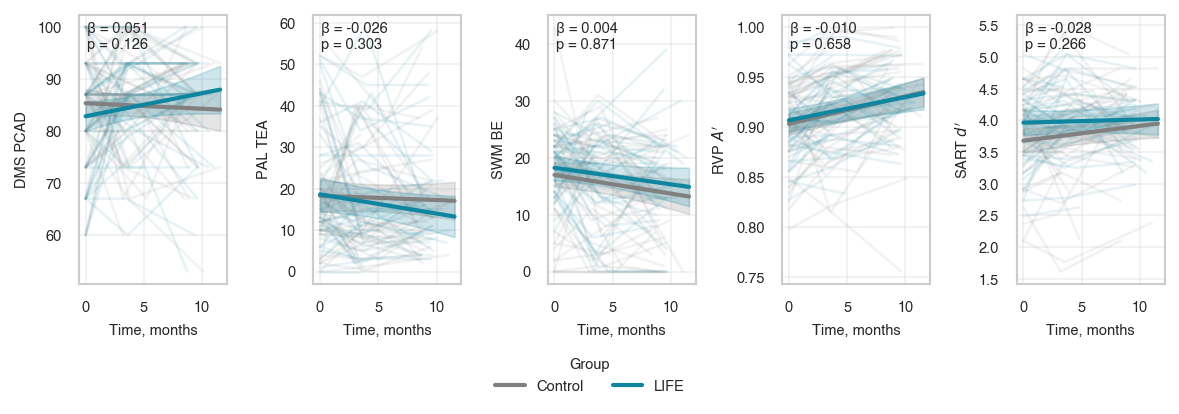

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  exponent_fc
No. Observations:   220      Method:              REML       
No. Groups:         82       Scale:               0.3254     
Min. group size:    2        Log-Likelihood:      -286.9163  
Max. group size:    3        Converged:           Yes        
Mean group size:    2.7                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.082    0.134 -0.611 0.541 -0.346  0.181
time                0.030    0.014  2.065 0.039  0.002  0.058
age_bas            -0.190    0.102 -1.866 0.062 -0.390  0.010
education_bas      -0.179    0.103 -1.744 0.081 -0.381  0.022
gender_f           -0.044    0.100 -0.444 0.657 -0.239  0.151
handedness_r       -0.087    0.102 -0.852 0.394 -0.288  0.113
group_life          

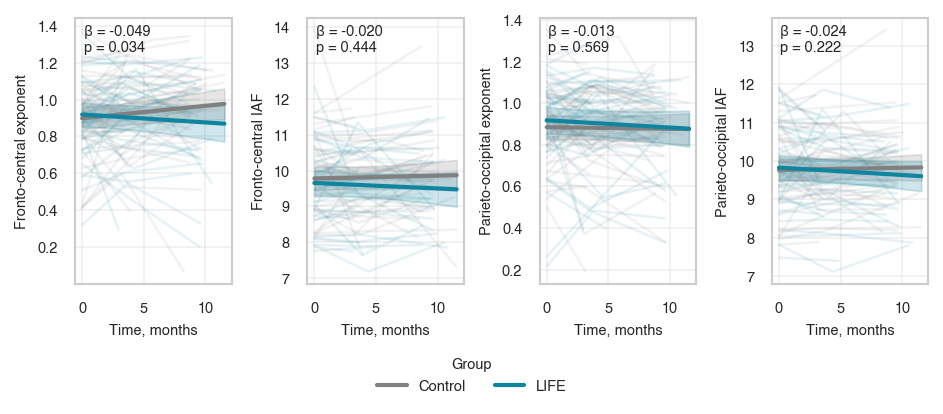

In [146]:
### LMMs

### CONTINUOUS TIME

vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 
        'PALTEA': 'PAL TEA', 
        'SWMBE': 'SWM BE', 
        'RVPA': "RVP $\\mathit{A'}$",
        'd_prime': "SART $\\mathit{d'}$"
    },
    'eeg': {
         'exponent_fc': 'Fronto-central exponent', 
         'iaf_fc': 'Fronto-central IAF', 
         'exponent_po': 'Parieto-occipital exponent', 
         'iaf_po': 'Parieto-occipital IAF'
    }
}

# plot params
colors = {'0.0': 'grey', '1.0': '#0F85A0FF'}   # '0.0': '#5785C1FF', '1.0': '#CB7A5CFF' 
legend_dict = {0.0: 'Control', 1.0: 'LIFE'} 
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 60/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 60/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]

        df_lme = df[[f'subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]
        df_lme = df_lme.sort_values(by=['subject', 'tp'])

        # create time and baseline variables
        df_lme['time'] = df_lme.groupby('subject')['age'].transform(lambda x: (x - x.iloc[0]) * 12)
        # df_lme['time'] = df_lme.groupby('subject')['age'].transform(lambda x: x - x.iloc[0])
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')
        
        # keep only subjects with multiple timepoints and necessary data
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(stats.zscore)
        
        # mixed-effects model
        formula = f"{dv} ~ time * (age_bas + education_bas + gender_f + handedness_r + group_life)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula='~time')
        results = model.fit()
        print(results.summary())        

        # # calc r2
        # r2_marg, r2_cond = r_squared_calculator.calculate_r2_nakagawa(results)
    
        # print("\nNakagawa & Schielzeth R-squared values:")
        # print(f"Marginal R² = {r2_marg:.3f}")
        # print(f"Conditional R² = {r2_cond:.3f}\n")

        # df for group predictions
        time_grid = np.linspace(df_lme['time'].min(), df_lme['time'].max(), 100)
        predictions = []
        for group_life in df_lme['group_life'].unique():
            # calculate mean
            pred_df = pd.DataFrame({
                'time': time_grid,
                'group_life': group_life,
                'age_bas': [df_lme_z['age_bas'].mean()] * len(time_grid),
                'education_bas': [df_lme_z['education_bas'].mean()] * len(time_grid),
                'gender_f': [df_lme_z['gender_f'].mean()] * len(time_grid),
                'handedness_r': [df_lme_z['handedness_r'].mean()] * len(time_grid),
            })
            pred_df['predicted'] = results.predict(pred_df)
            pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]
            
            # calculate CIs
            design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
            prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:12, :12] @ design_matrix.T) # change the :10 if different formula
            se = np.sqrt(prediction_var)
            pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
            pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]
            
            predictions.append(pred_df)
        predictions = pd.concat(predictions)

        ### plotting

        # spaghetti plot
        for subject, group in df_lme.groupby('subject'):
            group_color = colors[str(group['group_life'].iloc[0])]  # get group color
            ax.plot(group['time'], group[dv], alpha=0.1, color=group_color, label='_nolegend_')

        # prediction plot
        for group_life in predictions['group_life'].unique():
            group_data = predictions[predictions['group_life'] == group_life]
            ax.plot(group_data['time'], group_data['predicted_orig'],
                    label=legend_dict[group_life], linewidth=2, color=colors[str(group_life)])
            ax.fill_between(group_data['time'], group_data['ci_lower'], group_data['ci_upper'],
                            alpha=0.2, color=colors[str(group_life)])
        
        # interaction annotation
        interaction_idx = results.model.exog_names.index('time:group_life')
        beta = results.params[interaction_idx]
        pval = results.pvalues[interaction_idx]
        ptext = '< 0.001' if pval < 0.001 else f'= {pval:.3f}'
        ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                transform=ax.transAxes, verticalalignment='top')

        ax.set_xlabel('Time, months')
        ax.set_ylabel(dv_label)

    plt.tight_layout()
    plt.legend(loc='lower center', ncol=2, title='Group', frameon=False, title_fontsize=7,
               bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)
    
    plt.savefig(os.path.join(plots_dir, f'LME_time_{type}.pdf'), format='pdf', bbox_inches='tight', dpi=300)

    plt.show()
    plt.close()

### POST-HOC TESTS

#### WHOLE GROUP LME MODELS

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   DMSPCAD  
No. Observations:   237       Method:               REML     
No. Groups:         85        Scale:                0.7638   
Min. group size:    2         Log-Likelihood:       -332.2587
Max. group size:    3         Converged:            Yes      
Mean group size:    2.8                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.054    0.092 -0.584 0.559 -0.234  0.127
time                0.162    0.189  0.857 0.392 -0.208  0.532
age_bas            -0.193    0.094 -2.059 0.039 -0.376 -0.009
education_bas       0.047    0.095  0.493 0.622 -0.140  0.234
gender_f           -0.125    0.094 -1.338 0.181 -0.309  0.058
handedness_r       -0.079    0.097 -0.822 0.411 -0.269  0.110
time:age_bas       -

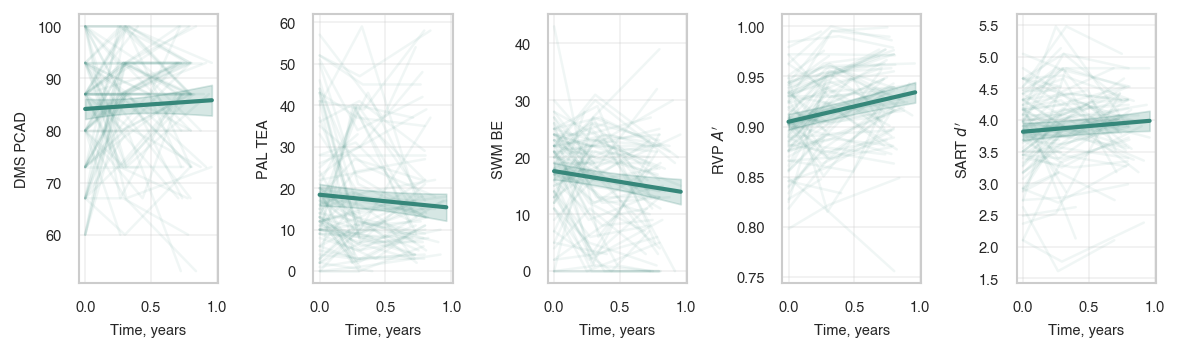

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  exponent_fc
No. Observations:   220      Method:              REML       
No. Groups:         82       Scale:               0.3317     
Min. group size:    2        Log-Likelihood:      -273.1352  
Max. group size:    3        Converged:           Yes        
Mean group size:    2.7                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.044    0.097 -0.452 0.651 -0.235  0.147
time                0.114    0.132  0.867 0.386 -0.144  0.373
age_bas            -0.177    0.098 -1.805 0.071 -0.370  0.015
education_bas      -0.176    0.102 -1.724 0.085 -0.376  0.024
gender_f           -0.047    0.099 -0.471 0.638 -0.240  0.147
handedness_r       -0.088    0.102 -0.863 0.388 -0.287  0.111
time:age_bas        

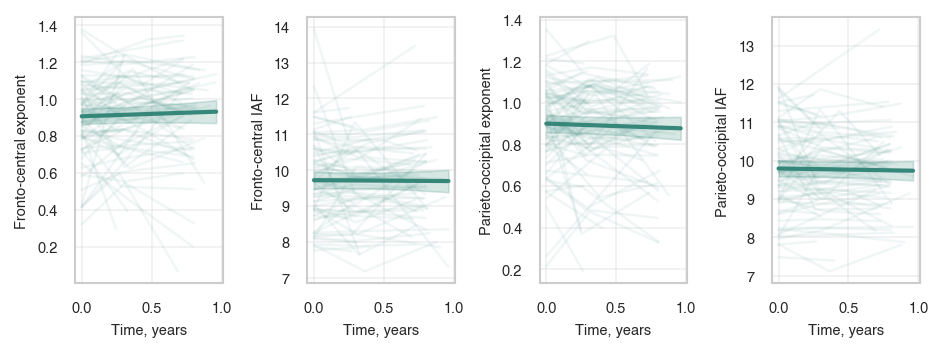

In [147]:
### WHOLE GROUP LMMs

vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 
        'PALTEA': 'PAL TEA', 
        'SWMBE': 'SWM BE', 
        'RVPA': "RVP $\\mathit{A'}$",
        'd_prime': "SART $\\mathit{d'}$"
    },
    'eeg': {
         'exponent_fc': 'Fronto-central exponent', 
         'iaf_fc': 'Fronto-central IAF', 
         'exponent_po': 'Parieto-occipital exponent', 
         'iaf_po': 'Parieto-occipital IAF'
    }
}

# plot params
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 60/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 60/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]

        df_lme = df[[f'subject', 'tp', 'age', 'gender_f', 'education', 'handedness_r', dv]]
        df_lme = df_lme.sort_values(by=['subject', 'tp'])

        # create time and baseline variables
        df_lme['time'] = df_lme.groupby('subject')['age'].transform(lambda x: x - x.iloc[0])
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')
        
        # keep only subjects with multiple timepoints and necessary data
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(stats.zscore)
        
        # mixed-effects model
        formula = f"{dv} ~ time * (age_bas + education_bas + gender_f + handedness_r)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula='~time')
        results = model.fit()
        print(results.summary())

        # calc r2
        # r2_marg, r2_cond = r_squared_calculator.calculate_r2_nakagawa(results)
    
        # print("\nNakagawa & Schielzeth R-squared values:")
        # print(f"Marginal R² = {r2_marg:.3f}")
        # print(f"Conditional R² = {r2_cond:.3f}\n")

        # Predictions
        time_grid = np.linspace(df_lme['time'].min(), df_lme['time'].max(), 100)
        pred_df = pd.DataFrame({
            'time': time_grid,
            'age_bas': [df_lme_z['age_bas'].mean()] * len(time_grid),
            'education_bas': [df_lme_z['education_bas'].mean()] * len(time_grid),
            'gender_f': [df_lme_z['gender_f'].mean()] * len(time_grid),
            'handedness_r': [df_lme_z['handedness_r'].mean()] * len(time_grid),
        })
        pred_df['predicted'] = results.predict(pred_df)
        pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]
            
        # calculate CIs
        design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
        prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:10, :10] @ design_matrix.T)
        se = np.sqrt(prediction_var)
        pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
        pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]

        ### plotting

        for subject, group in df_lme.groupby('subject'):
            ax.plot(group['time'], group[dv], alpha=0.07, color='#36877AFF')

        ax.plot(pred_df['time'], pred_df['predicted_orig'], linewidth=2, color='#36877AFF')
        ax.fill_between(pred_df['time'], pred_df['ci_lower'], pred_df['ci_upper'], alpha=0.2, color='#36877AFF')

        ax.set_xlabel('Time, years')
        ax.set_ylabel(dv_label)

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'LME_time_{type}_wholesample.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

#### SENSITIVITY ANALYSIS I - DISCRETE TPs

In [ ]:
### LMMs

### DISCRETE TP

vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 
        'PALTEA': 'PAL TEA', 
        'RVPA': "RVP $\\mathit{A'}$", 
        'SWMBE': 'SWM BE', 
        'd_prime': "SART $\\mathit{d'}$"
    },
    'eeg': {
         'exponent_fc': 'Fronto-central exponent', 
         'iaf_fc': 'Fronto-central IAF', 
         'exponent_po': 'Parieto-occipital exponent', 
         'iaf_po': 'Parieto-occipital IAF'
    }
}

# plot params
colors = {'0.0': 'grey', '1.0': '#0F85A0FF'}    # '0.0': '#5785C1FF', '1.0': '#CB7A5CFF'
legend_dict = {0.0: 'Control', 1.0: 'LIFE'} 
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 80/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 80/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]
            
        df_lme = df[['subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]
        df_lme = df_lme.sort_values(by=['subject', 'tp'])

        # categorise tp and create baseline variables
        df_lme['tp'] = df_lme['tp'].astype('category')
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')

        # keep only subjects with multiple timepoints and necessary data
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(stats.zscore)

        # mixed-effects model
        formula = f"{dv} ~ tp * (age_bas + education_bas + gender_f + handedness_r + group_life)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula="~tp")
        results = model.fit()
        print(results.summary())

        # # calc r2
        # r2_marg, r2_cond = r_squared_calculator.calculate_r2_nakagawa(results)
    
        # print("\nNakagawa & Schielzeth R-squared values:")
        # print(f"Marginal R² = {r2_marg:.3f}")
        # print(f"Conditional R² = {r2_cond:.3f}\n")
            
        # df for group and tp predictions
        pred_df = pd.DataFrame({
            'tp': np.repeat([1, 2, 3], 2),
            'group_life': np.tile([0.0, 1.0], 3)
        })
        # calculate mean
        for col in ['age_bas', 'education_bas', 'gender_f', 'handedness_r']:
            pred_df[col] = [df_lme_z[col].mean()] * 6

        pred_df['tp'] = pred_df['tp'].astype('category')
        pred_df['predicted'] = results.predict(pred_df)
        pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]

        # calculate CIs
        design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
        prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:18, :18] @ design_matrix.T) # change the :10 if different formula
        se = np.sqrt(prediction_var)
        pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
        pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]

        ### plotting
        
        # spaghetti plot
        for subject, group in df_lme.groupby('subject'):
            group_color = colors[str(group['group_life'].iloc[0])]  # get group color
            ax.plot(
                group['tp'], group[dv],
                alpha=0.075, color=group_color, label='_nolegend_'
            )

        # prediction plot
        for group in [0.0, 1.0]:
            group_data = pred_df[pred_df['group_life'] == group]
            ax.plot(group_data['tp'], group_data['predicted_orig'], 
                    label=legend_dict[group], linewidth=2, 
                    color=colors[str(group)])
            ax.fill_between(group_data['tp'], 
                            group_data['ci_lower'],
                            group_data['ci_upper'],
                            alpha=0.2, color=colors[str(group)])

        # interaction annotations
        tp1_idx = results.model.exog_names.index('group_life')
        tp1_b, tp1_p = results.params[tp1_idx], results.pvalues[tp1_idx]
        tp1_ptext = '< 0.001' if tp1_p < 0.001 else f'= {tp1_p:.3f}'
        
        tp2_idx = results.model.exog_names.index('tp[T.2]:group_life')
        tp2_b, tp2_p = results.params[tp2_idx], results.pvalues[tp2_idx]
        tp2_ptext = '< 0.001' if tp2_p < 0.001 else f'= {tp2_p:.3f}'
        
        tp3_idx = results.model.exog_names.index('tp[T.3]:group_life')
        tp3_b, tp3_p = results.params[tp3_idx], results.pvalues[tp3_idx]
        tp3_ptext = '< 0.001' if tp3_p < 0.001 else f'= {tp3_p:.3f}'

        ax.set_title(
            f'T1:\nβ = {tp1_b:.3f}, p {tp1_ptext}\n'
            f'T1-to-T2:\nβ = {tp2_b:.3f}, p {tp2_ptext}\n'
            f'T1-to-T3:\nβ = {tp3_b:.3f}, p {tp3_ptext}'
        )

        ax.set_xlabel('Timepoint')
        ax.set_ylabel(dv_label)

    plt.tight_layout()
    plt.legend(loc='lower center', ncol=2, title='Group', frameon=False, title_fontsize=7,
               bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)
    
    plt.savefig(os.path.join(plots_dir, f'LME_discrete_{type}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    
    plt.show()
    plt.close()

#### SENSITIVITY ANALYSIS II - AGE MATCHED GROUPS AT T1

In [134]:
### SENSITIVITY ANALYSIS - to rectify sig. diff in age between groups at baseline

# Filter control group participants at timepoint 1
control_group_baseline = df[(df['group_life'] == 0) & (df['tp'] == 1)]

# Sort by age to find the youngest participants
control_group_sorted = control_group_baseline.sort_values(by='age')

# Select the youngest participants to remove
youngest_participants = control_group_sorted['subject'].iloc[:2]  # Adjust the number to remove more participants if needed
print("Youngest participants to remove:", youngest_participants.tolist())

Youngest participants to remove: [95, 89]


In [135]:
# Remove the selected participants from the full dataframe
df_sensitivity = df[~df['subject'].isin(youngest_participants)]

# Filter baseline data (tp == 1)
age_bas_control = df_sensitivity[(df_sensitivity['group_life'] == 0) & (df_sensitivity['tp'] == 1)]['age']
age_bas_life = df_sensitivity[(df_sensitivity['group_life'] == 1) & (df_sensitivity['tp'] == 1)]['age']

# Perform t-test to compare baseline age between groups
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(age_bas_control, age_bas_life)

# Print the results
print(f"T-test: t-stat = {t_stat:.3f}, p = {p_value:.3f}")

T-test: t-stat = -1.887, p = 0.062


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   DMSPCAD  
No. Observations:   234       Method:               REML     
No. Groups:         84        Scale:                0.7615   
Min. group size:    2         Log-Likelihood:       -328.2425
Max. group size:    3         Converged:            Yes      
Mean group size:    2.8                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.048    0.130  0.368 0.713 -0.206  0.302
time               -0.102    0.265 -0.385 0.701 -0.622  0.418
age_bas            -0.140    0.096 -1.451 0.147 -0.329  0.049
education_bas       0.068    0.096  0.710 0.478 -0.121  0.257
gender_f           -0.149    0.095 -1.567 0.117 -0.335  0.037
handedness_r       -0.084    0.097 -0.870 0.384 -0.274  0.106
group_life         -

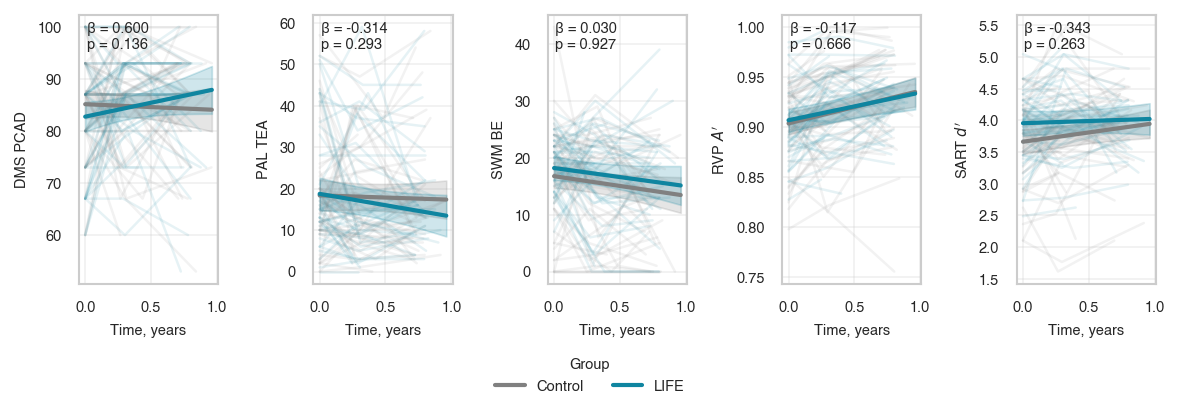

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  exponent_fc
No. Observations:   217      Method:              REML       
No. Groups:         81       Scale:               0.3294     
Min. group size:    2        Log-Likelihood:      -268.3897  
Max. group size:    3        Converged:           Yes        
Mean group size:    2.7                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.080    0.136 -0.588 0.556 -0.346  0.186
time                0.352    0.174  2.022 0.043  0.011  0.694
age_bas            -0.193    0.103 -1.879 0.060 -0.394  0.008
education_bas      -0.183    0.104 -1.755 0.079 -0.386  0.021
gender_f           -0.043    0.100 -0.427 0.670 -0.239  0.154
handedness_r       -0.086    0.103 -0.837 0.402 -0.288  0.116
group_life          

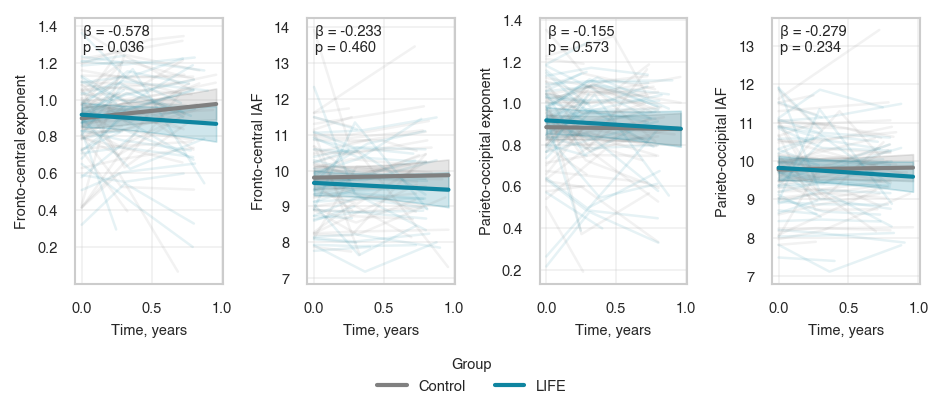

In [ ]:
### LMMs

### CONTINUOUS TIME

vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 
        'PALTEA': 'PAL TEA', 
        'SWMBE': 'SWM BE', 
        'RVPA': "RVP $\\mathit{A'}$",
        'd_prime': "SART $\\mathit{d'}$"
    },
    'eeg': {
         'exponent_fc': 'Fronto-central exponent', 
         'iaf_fc': 'Fronto-central IAF', 
         'exponent_po': 'Parieto-occipital exponent', 
         'iaf_po': 'Parieto-occipital IAF'
    }
}

# plot params
colors = {'0.0': 'grey', '1.0': '#0F85A0FF'}   # '0.0': '#5785C1FF', '1.0': '#CB7A5CFF' 
legend_dict = {0.0: 'Control', 1.0: 'LIFE'} 
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 60/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 60/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]

        df_lme = df_sensitivity[[f'subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]
        df_lme = df_lme.sort_values(by=['subject', 'tp'])

        # create time and baseline variables
        df_lme['time'] = df_lme.groupby('subject')['age'].transform(lambda x: x - x.iloc[0])
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')
        
        # keep only subjects with multiple timepoints and necessary data
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(stats.zscore)
        
        # mixed-effects model
        formula = f"{dv} ~ time * (age_bas + education_bas + gender_f + handedness_r + group_life)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula='~time')
        results = model.fit()
        print(results.summary())

        # # calc r2
        # r2_marg, r2_cond = r_squared_calculator.calculate_r2_nakagawa(results)
    
        # print("\nNakagawa & Schielzeth R-squared values:")
        # print(f"Marginal R² = {r2_marg:.3f}")
        # print(f"Conditional R² = {r2_cond:.3f}\n")

        # df for group predictions
        time_grid = np.linspace(df_lme['time'].min(), df_lme['time'].max(), 100)
        predictions = []
        for group_life in df_lme['group_life'].unique():
            # calculate mean
            pred_df = pd.DataFrame({
                'time': time_grid,
                'group_life': group_life,
                'age_bas': [df_lme_z['age_bas'].mean()] * len(time_grid),
                'education_bas': [df_lme_z['education_bas'].mean()] * len(time_grid),
                'gender_f': [df_lme_z['gender_f'].mean()] * len(time_grid),
                'handedness_r': [df_lme_z['handedness_r'].mean()] * len(time_grid),
            })
            pred_df['predicted'] = results.predict(pred_df)
            pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]
            
            # calculate CIs
            design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
            prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:12, :12] @ design_matrix.T) # change the :10 if different formula
            se = np.sqrt(prediction_var)
            pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
            pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]
            
            predictions.append(pred_df)
        predictions = pd.concat(predictions)

        ### plotting

        # spaghetti plot
        for subject, group in df_lme.groupby('subject'):
            group_color = colors[str(group['group_life'].iloc[0])]  # get group color
            ax.plot(group['time'], group[dv], alpha=0.1, color=group_color, label='_nolegend_')

        # prediction plot
        for group_life in predictions['group_life'].unique():
            group_data = predictions[predictions['group_life'] == group_life]
            ax.plot(group_data['time'], group_data['predicted_orig'],
                    label=legend_dict[group_life], linewidth=2, color=colors[str(group_life)])
            ax.fill_between(group_data['time'], group_data['ci_lower'], group_data['ci_upper'],
                            alpha=0.2, color=colors[str(group_life)])
        
        # interaction annotation
        interaction_idx = results.model.exog_names.index('time:group_life')
        beta = results.params[interaction_idx]
        pval = results.pvalues[interaction_idx]
        ptext = '< 0.001' if pval < 0.001 else f'= {pval:.3f}'
        ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                transform=ax.transAxes, verticalalignment='top')

        ax.set_xlabel('Time, years')
        ax.set_ylabel(dv_label)

    plt.tight_layout()
    plt.legend(loc='lower center', ncol=2, title='Group', frameon=False, title_fontsize=7,
               bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)
    
    plt.savefig(os.path.join(plots_dir, f'LME_time_{type}_agematched.pdf'), format='pdf', bbox_inches='tight', dpi=300)

    plt.show()
    plt.close()

#### CORRELATIONS AT BASELINE + CHANGE

In [16]:
### CORRELATIONS

df_corr = df.copy()

### T1 WHOLE SAMPLE

df_baseline = df_corr[df_corr['tp'] == 1]

# List of variables to correlate (excluding categorical variables)
variables_bas = ['age', 'education', 'gender_f', 'handedness_r', 'DMSPCAD', 'PALTEA', 'RVPA', 'SWMBE', 'd_prime', 'exponent_po', 'iaf_po', 'exponent_fc', 'iaf_fc']

df_corr_bas = df_baseline[variables_bas]
corr_matrix_bas = df_corr_bas.rcorr()

output_file = "results/correlations/correlations_baseline_whole_sample.xlsx"
corr_matrix_bas.to_excel(output_file, index=False)

print("Correlations for whole sample at T1:")
display(corr_matrix_bas)

### CHANGE FROM T1-T3 FOR GROUPS AND WHOLE SAMPLE

# Variables to calculate changes for
variables_change = ['DMSPCAD', 'PALTEA', 'RVPA', 'SWMBE', 'd_prime', 'exponent_po', 'iaf_po', 'exponent_fc', 'iaf_fc']

# Function to calculate participant changes
def calculate_participant_changes(participant_data, variables_change):
    changes = {}
    baseline_data = participant_data[participant_data['tp'] == 1]
    
    # Baseline demographic data
    changes['age_bas'] = baseline_data['age'].values[0]  # Baseline age
    changes['education_bas'] = baseline_data['education'].values[0]  # Baseline education
    changes['gender_f'] = baseline_data['gender_f'].values[0]
    changes['handedness_r'] = baseline_data['handedness_r'].values[0]
    
    # Calculate changes for each variable
    for var in variables_change:
        t1 = participant_data[participant_data['tp'] == 1][var].values
        t2 = participant_data[participant_data['tp'] == 2][var].values
        t3 = participant_data[participant_data['tp'] == 3][var].values
        
        # Compute T1-T2 change if both time points exist
        if len(t1) > 0 and len(t2) > 0:
            changes[f'{var}_T1_T2'] = t2[0] - t1[0]
        
        # Compute T1-T3 change if both time points exist
        if len(t1) > 0 and len(t3) > 0:
            changes[f'{var}_T1_T3'] = t3[0] - t1[0]
    
    return changes

# Calculate changes for all participants
all_changes = []
for subject, participant_data in df_corr.groupby('subject'):
    changes = calculate_participant_changes(participant_data, variables_change)
    changes['subject'] = subject
    changes['group_life'] = participant_data['group_life'].iloc[0]
    all_changes.append(changes)

# Create a DataFrame of all calculated changes
changes_df = pd.DataFrame(all_changes)

# Function to compute correlations using pingouin's rcorr()
def compute_rcorr(data):
    return pg.rcorr(data)

# Compute correlations for each group and whole sample
group_correlations = {}
for group in [0, 1]:  # Assuming group_life has values 0 (Control) and 1 (LIFE)
    group_data = changes_df[changes_df['group_life'] == group].drop(['subject', 'group_life'], axis=1)
    group_correlations[f'Group {group}'] = compute_rcorr(group_data)

whole_sample_correlations = compute_rcorr(
    changes_df.drop(['subject', 'group_life'], axis=1)
)

# Function to compute correlations and save to Excel
def compute_and_save_rcorr(data, filename):
    corr_results = pg.rcorr(data)
    corr_results.to_excel(f'results/correlations/{filename}', index=False)
    return corr_results

# Compute and save correlations for each group and whole sample
group_correlations = {}
for group in [0, 1]:  # Assuming group_life has values 0 (Control) and 1 (LIFE)
    group_data = changes_df[changes_df['group_life'] == group].drop(['subject', 'group_life'], axis=1)
    group_correlations[f'Group {group}'] = compute_and_save_rcorr(
        group_data, 
        f'correlations_group_{group}.xlsx'
    )

# Compute and save whole sample correlations
whole_sample_correlations = compute_and_save_rcorr(
    changes_df.drop(['subject', 'group_life'], axis=1), 
    'correlations_whole_sample.xlsx'
)

# Display results
print("Correlations for group 0 (Control):")
display(group_correlations['Group 0'])

print("\nCorrelations for group 1 (LIFE):")
display(group_correlations['Group 1'])

print("\nCorrelations for whole sample:")
display(whole_sample_correlations)



Correlations for whole sample at T1:


,age,education,gender_f,handedness_r,DMSPCAD,PALTEA,RVPA,SWMBE,d_prime,exponent_po,iaf_po,exponent_fc,iaf_fc
age,-,,,,*,***,***,***,*,*,,*,*
education,-0.183,-,,,,,*,,,,*,,*
gender_f,-0.004,0.053,-,,,,,,,,,,
handedness_r,0.051,-0.049,0.19,-,,,,,,,,,
DMSPCAD,-0.237,0.059,-0.074,-0.156,-,,**,,,,,,
PALTEA,0.335,-0.124,-0.077,0.131,-0.18,-,*,**,,,,,
RVPA,-0.344,0.214,0.085,-0.0,0.26,-0.242,-,*,**,,,,
SWMBE,0.402,-0.097,-0.079,0.008,-0.093,0.289,-0.227,-,,,,,
d_prime,-0.221,0.061,0.106,0.052,0.068,0.047,0.264,-0.047,-,,,,*
exponent_po,-0.237,0.125,0.093,0.058,-0.114,-0.121,0.029,-0.048,0.03,-,,***,*


Correlations for group 0 (Control):


,age_bas,education_bas,gender_f,handedness_r,DMSPCAD_T1_T2,DMSPCAD_T1_T3,PALTEA_T1_T2,PALTEA_T1_T3,RVPA_T1_T2,RVPA_T1_T3,...,d_prime_T1_T2,d_prime_T1_T3,exponent_po_T1_T2,exponent_po_T1_T3,iaf_po_T1_T2,iaf_po_T1_T3,exponent_fc_T1_T2,exponent_fc_T1_T3,iaf_fc_T1_T2,iaf_fc_T1_T3
age_bas,-,,,,,,,,,,...,*,*,,,,,,,,
education_bas,-0.17,-,,,,,,,,*,...,,,,,,,,,,
gender_f,0.09,-0.105,-,*,,**,,,,,...,**,,,,,,,,,
handedness_r,0.108,-0.097,0.271,-,,,,,,,...,,,,,,,,,,
DMSPCAD_T1_T2,-0.136,-0.013,0.273,0.135,-,***,,,,,...,,,,,,,,,,
DMSPCAD_T1_T3,-0.006,0.084,0.478,0.059,0.777,-,,,,,...,,,,,,,,,,
PALTEA_T1_T2,0.154,0.082,0.051,0.027,-0.152,-0.008,-,***,,,...,,,,,,,,,,
PALTEA_T1_T3,0.278,0.124,0.022,-0.046,-0.133,-0.058,0.704,-,,,...,,,,,,,,,,
RVPA_T1_T2,0.024,-0.21,0.037,0.099,-0.05,-0.07,0.14,0.042,-,***,...,,,,,,,,,,
RVPA_T1_T3,-0.015,-0.355,0.039,0.252,0.191,0.221,0.056,-0.047,0.633,-,...,,*,*,**,,,**,*,,



Correlations for group 1 (LIFE):


,age_bas,education_bas,gender_f,handedness_r,DMSPCAD_T1_T2,DMSPCAD_T1_T3,PALTEA_T1_T2,PALTEA_T1_T3,RVPA_T1_T2,RVPA_T1_T3,...,d_prime_T1_T2,d_prime_T1_T3,exponent_po_T1_T2,exponent_po_T1_T3,iaf_po_T1_T2,iaf_po_T1_T3,exponent_fc_T1_T2,exponent_fc_T1_T3,iaf_fc_T1_T2,iaf_fc_T1_T3
age_bas,-,,,,,,,,,,...,,,,***,,,,,,
education_bas,-0.22,-,,,,,,,,,...,,,,,,,,,,
gender_f,-0.083,0.171,-,,,,,,,,...,**,,,,,,,,,
handedness_r,-0.021,-0.012,0.105,-,,,,,*,,...,,,,,,,,,,
DMSPCAD_T1_T2,0.163,0.005,0.011,-0.079,-,***,,,,,...,,,,,,,,,,
DMSPCAD_T1_T3,-0.088,0.074,0.235,-0.153,0.752,-,,,,,...,,,,,,,*,,,
PALTEA_T1_T2,0.035,-0.111,-0.084,-0.098,0.063,0.242,-,**,,,...,,,,,,,,,,
PALTEA_T1_T3,-0.188,-0.061,-0.1,-0.208,0.022,0.238,0.565,-,,,...,,,,,,,,,,
RVPA_T1_T2,0.194,0.238,-0.091,-0.336,0.043,0.086,0.039,0.088,-,***,...,,*,,,,,,,,
RVPA_T1_T3,-0.224,0.342,-0.067,-0.273,-0.269,-0.086,0.083,0.069,0.621,-,...,,,,,,,,,,



Correlations for whole sample:


,age_bas,education_bas,gender_f,handedness_r,DMSPCAD_T1_T2,DMSPCAD_T1_T3,PALTEA_T1_T2,PALTEA_T1_T3,RVPA_T1_T2,RVPA_T1_T3,...,d_prime_T1_T2,d_prime_T1_T3,exponent_po_T1_T2,exponent_po_T1_T3,iaf_po_T1_T2,iaf_po_T1_T3,exponent_fc_T1_T2,exponent_fc_T1_T3,iaf_fc_T1_T2,iaf_fc_T1_T3
age_bas,-,,,,,,,,,,...,*,*,,,,,,,,
education_bas,-0.183,-,,,,,,,,,...,,,,,,,,,,
gender_f,-0.004,0.053,-,,,**,,,,,...,,,,,,,*,,,
handedness_r,0.051,-0.049,0.19,-,,,,,,,...,,,,,,,,,,
DMSPCAD_T1_T2,-0.0,0.0,0.139,0.043,-,***,,,,,...,,,,,,,,,,
DMSPCAD_T1_T3,-0.022,0.077,0.33,-0.044,0.765,-,,,,,...,,,,,,,,,,
PALTEA_T1_T2,0.101,-0.016,-0.004,-0.024,-0.086,0.084,-,***,,,...,,,,,,,,,,
PALTEA_T1_T3,0.077,0.019,-0.014,-0.111,-0.09,0.06,0.653,-,,,...,,,,,*,,,,,
RVPA_T1_T2,0.09,0.01,-0.021,-0.076,-0.012,-0.005,0.104,0.049,-,***,...,,,,,,,,,,
RVPA_T1_T3,-0.105,0.006,0.006,0.037,0.034,0.093,0.066,0.004,0.621,-,...,,,,,,,**,*,,


#### SUBSET - RESPONDERS COGDRISK

In [17]:
import csv

# Data for the CSV file
data = [
    ["Predictor", "Coef (SE)", "P", "95% CI (Low - High)"],
    ["Intercept", "0.083 (0.147)", "0.574", "-0.205 - 0.370"],
    ["time", "0.061 (0.203)", "0.763", "-0.337 - 0.459"],
    ["age_bas", "-0.336 (0.110)", "0.002", "-0.552 - -0.119"],
    ["education_bas", "-0.366 (0.112)", "0.001", "-0.584 - -0.147"],
    ["gender_f", "0.081 (0.110)", "0.462", "-0.135 - 0.298"],
    ["handedness_r", "-0.157 (0.111)", "0.157", "-0.374 - 0.060"],
    ["group_life", "-0.130 (0.218)", "0.552", "-0.557 - 0.297"],
    ["time:age_bas", "0.216 (0.164)", "0.187", "-0.105 - 0.537"],
    ["time:education_bas", "0.221 (0.154)", "0.151", "-0.081 - 0.523"],
    ["time:gender_f", "-0.134 (0.153)", "0.384", "-0.434 - 0.167"],
    ["time:handedness_r", "-0.021 (0.146)", "0.885", "-0.308 - 0.266"],
    ["time:group_life", "-0.233 (0.315)", "0.460", "-0.850 - 0.384"]
]

# Save the data to a CSV file
filename = "results/lme/agematched/LME_IAF_FC_results_agematched.csv"

with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(data)